In [3]:
import pandas as pd
import numpy as np

import spacy
import nltk
import re

import random
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

import json
import os

import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

tqdm.pandas(desc='progress-bar')

In [17]:
df = pd.read_csv('data/snopes_processed.tsv', sep='\t')
df = df.replace(np.nan, '', regex=True)
df = df['claim'].astype(str)

def count(x):
    print(x['claim'])
    return len(x['claim'].split[' '])

df['tokens'] = df.apply(count, axis=1)
df

TypeError: count() got an unexpected keyword argument 'axis'

In [2]:
stop = set(stopwords.words('english') + list(string.punctuation))
stemmer = PorterStemmer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

def preprocess(text):
    try:
        text = text.lower()
        tokens = word_tokenize(text)
#         tokens = [t for t in tokens if not t in stop]
        tokens = [re.sub(re_punct, ' ', t) for t in tokens]
        tokens = [t for t in tokens if len(t) > 2]
#         tokens = [stemmer.stem(t) for t in tokens]
        if len(tokens) == 0:
            return ' '
        else:
            return ' '.join(tokens)
    except:
        return ' '
    
def tokenize_count(row):
    return len(row.split(' '))



In [3]:
def get_splits(X, y, max_words = 20000, MAX_SEQUENCE_LENGTH = 100, EMBEDDING_DIM = 300):
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    tokenizer.fit_on_texts(X)

    X = tokenizer.texts_to_sequences(X)
    Y = pd.get_dummies(y).values
    # print(X[0])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,  padding="post", truncating="post")
    # print(X[10])

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                        random_state = 42)

    # print(y_train[100])

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
    
    return x_train, x_test, y_train, y_test, word_index

In [8]:
data_train = pd.read_csv('data/newsfiles/fulltrain.csv', names=['label', 'text'])
categories = {1:"Satire",2:"Hoax",
              3:"Propaganda",4:"Trusted"}
def to_label(cat):
    return categories[cat]
    
    
data_train['label'] = data_train['label'].apply(to_label)
data_train.tail()

,label,text
48849,Trusted,The ruling Kuomintang (KMT) has claimed owners...
48850,Trusted,The Taipei city government has encouraged the ...
48851,Trusted,President Ma Ying-jeou said Friday that a park...
48852,Trusted,The families of the four people who were kille...
48853,Trusted,The Ministry of Finance will make public on Sa...


3    17870
1    14047
4     9995
2     6942
Name: label, dtype: int64


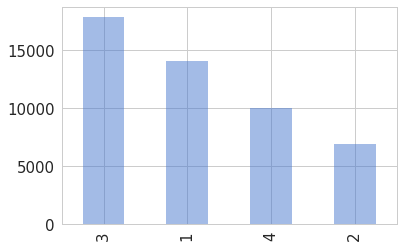

In [7]:
print(data_train['label'].value_counts())

data_train['label'].value_counts().plot(kind='bar', alpha=.5)

In [ ]:

def prep_fakeNewsNet():
    dfs = []
    for root, dirs, files in os.walk('data/FakeNewsNet/Data/'): 
        for filename in files:
            if filename.endswith('json'):
    #             print('%s/%s' % (root, filename))
                with open('%s/%s' % (root, filename)) as json_data:
                    data = json.load(json_data)
                    df = pd.DataFrame.from_dict(data, orient='index').T
                    df['label'] = root.split('/')[4]
                    df['collected_by'] = root.split('/')[3]
                    dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)#.set_index('number')   
    df['text_tokens'] = df['text'].progress_map(preprocess)
    df['title_tokens'] = df['title'].progress_map(preprocess)
    df.dropna(subset=['text'], inplace=True) 
    df = df[['text', 'text_tokens', 'title', 'title_tokens', 'label', 'collected_by']]
    df['token_count'] = df['text_tokens'].apply(tokenize_count)
    df['title_count'] = df['title_tokens'].apply(tokenize_count)
    return df

def get_fakeNewsNet():
    data_train = pd.read_csv('data/fakeNewsNet.csv', sep='\t')
    data_train['label'].value_counts().plot(kind='bar', alpha=.5)

    print('Loading data...')

    X = data_train['tokens'].values
    y = data_train['label']
 
    labels = data_train['label'].unique()
    print(labels)
    
    num_classes = len(labels)
    print(num_classes, 'classes')
    
    x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
    
    return x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y


df = prep_fakeNewsNet()
df.to_csv('data/fakeNewsNet.csv', sep='\t')
df.tail()


In [ ]:
def prep_fake_or_real_news():
    data_train = pd.read_csv('data/fake_or_real_news.csv')
    data_train['tokens'] = data_train['text'].progress_map(preprocess)
    
    data_train = data_train[data_train['tokens'].notnull()]
    data_train.reset_index(inplace=True)
    data_train.drop('index', inplace=True, axis=1)
    data_train.to_csv('data/fake_or_real_news.csv')

# prep_fake_or_real_news()

In [ ]:
def get_fake_or_real_news():
    data_train = pd.read_csv('data/fake_or_real_news.csv')
    data_train['label'].value_counts().plot(kind='bar', alpha=.5)

    print('Loading data...')

    X = data_train['tokens'].values
    y = data_train['label']

    classes = data_train['label'].unique()
    
    labels = data_train['label'].unique()
    print(labels)
    
    num_classes = len(labels)
    print(num_classes, 'classes')
    
    x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
    
    return x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y


# x_train, x_test, y_train, y_test, word_index, labels, num_classes = get_fake_or_real_news()

In [21]:
def get_politifact():
    data_train = pd.read_csv('data/politifact.tsv', sep='\t')

    data_train['ruling'].value_counts().plot(kind='bar', alpha=.5)

    data_train['label'] = '' 
    def label(row):
    #     print(row)
        if row in ['true', 'half-true', 'mostly-true']:
            return 'true'
        else:
            return 'false'

    data_train['label'] = data_train['ruling'].apply(label)
    print(data_train['label'].value_counts())

    print('Loading data...')
    
        ###############
    X  = data_train['statement__text'].values
    y = data_train['label']

    classes = data_train['label'].unique()
    
    labels = data_train['label'].unique()
    print(labels)
    
    num_classes = len(labels)
    print(num_classes, 'classes')
    
    x_train, x_test, y_train, y_test, word_index = get_splits(X, y)

    data_train['label'].value_counts().plot(kind='bar', alpha=.5)
    
    return x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y
 
# x_train, x_test, y_train, y_test, word_index, labels, num_classes = get_politifact()

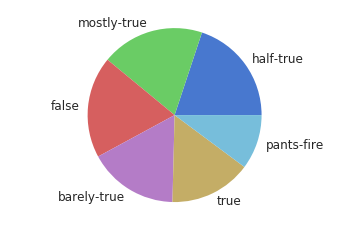

3806


,Unnamed: 0,Unnamed: 0.1,article__meta,link,quote,ruling,statement__source,statement__text
14393,14393,14393,"on Tuesday, October 23rd, 2007",/truth-o-meter/statements/2007/oct/23/mike-huc...,"1 out of 56 equals 'most'? No, it doesn't",pants-fire,Mike Huckabee,The signers of the Declaration of Independence...
14394,14394,14394,"on Monday, September 24th, 2007",/truth-o-meter/statements/2007/sep/24/rudy-giu...,"Famous, but not that famous",pants-fire,Rudy Giuliani,""" I 'm probably one of the four or five best -..."
14395,14395,14395,"on Monday, September 10th, 2007",/truth-o-meter/statements/2007/sep/10/bill-ric...,"Richardson re-writes Bible, Constitution",pants-fire,Bill Richardson,""" Iowa , for good reason , for constitutional ..."
14396,14396,14396,"on Thursday, August 30th, 2007",/truth-o-meter/statements/2007/aug/30/mike-gra...,"He's off, way off on who's in prison",pants-fire,Mike Gravel,""" In 1972 , we had a 179,000 human beings in j..."
14397,14397,14397,"on Friday, August 24th, 2007",/truth-o-meter/statements/2007/aug/24/joe-bide...,Irresponsible claim (and wrong medical diagnosis),pants-fire,Joe Biden,""" The president is brain - dead . """


In [22]:
# data_train = pd.read_csv('data/politifact.tsv', sep='\t')
# # data_train['ruling'].value_counts().plot(kind='bar', alpha=.5)

# import matplotlib.pyplot as plt
# from matplotlib.pyplot import pie, axis, show

# sums = data_train['ruling'].value_counts()
# axis('equal');
# pie(sums, labels=sums.index);
# show()

# print(len(data_train['statement__source'].unique()))

# data_train.tail()

In [ ]:

def prep_UCI():
    header = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME','TIMESTAMP']
    # b = business, t = science and technology, e = entertainment, m = health
    data_train = pd.read_csv('data/newsCorpora.csv', names=header,  sep='\t')
    
    data_train['TITLE'] = data_train['TITLE'].progress_map(preprocess)

    data_train = data_train[data_train['TITLE'].notnull()]
    data_train.drop('ID', inplace=True, axis=1)
    data_train.reset_index(inplace=True)
    data_train['token_count'] = data_train['TITLE'].apply(tokenize_count)
    data_train = data_train[data_train['token_count'] < 50]
    
    return data_train
    
# data_train = prep_UCI()
# data_train['CATEGORY'].value_counts().plot(kind='bar', alpha=.5)
# data_train['token_count'].hist(bins=10, alpha=.5)
# # data_train.to_csv('data/newsCorpora.csv', sep='\t')
# data_train.tail()
    

In [ ]:

# data_train['token_count'].hist(bins=10, alpha=.5)
# data_train['token_count'].describe()

In [ ]:

def prep_fake():
    data_train = pd.read_csv('data/fake.csv')
    data_train['text'] = data_train['text'].progress_map(preprocess)
    data_train['thread_title'] = data_train['thread_title'].progress_map(preprocess)

    data_train = data_train[data_train['thread_title'].notnull()]
    data_train.reset_index(inplace=True)
    data_train.drop('index', inplace=True, axis=1)
    data_train['token_count'] = data_train['thread_title'].apply(tokenize_count)
    return data_train

# fake_df = prep_fake()
# fake_df.to_csv('data/fake.csv')
# fake_df.tail()

In [ ]:
# fake_df['token_count'].hist(bins=10, alpha=.5)
# fake_df['token_count'].describe()


In [ ]:
def get_fact_fake():
    # print('Loading data...')

    fake_df = pd.read_csv('data/fake.csv')
    real_df = pd.read_csv('data/newsCorpora.csv', sep='\t')
    text = np.append(fake_df['thread_title'].values,  real_df['TITLE'].values)
    label = np.append( ['FALSE'] * len(fake_df), ['TRUE'] * len(real_df))
    data = {'text' : text, 'label': label}

    data_train = pd.DataFrame(data)
    data_train['label'].value_counts().plot(kind='bar', alpha=.5)
    print(data_train['label'].value_counts())
    data_train.tail()

    X  = data_train['text'].values
    y = data_train['label']

    labels = data_train['label'].unique()
    print(labels)

    num_classes = len(labels)
    print(num_classes, 'classes')

    x_train, x_test, y_train, y_test, word_index = get_splits(X, y)

#     data_train['label'].value_counts().plot(kind='bar', alpha=.5)

    return x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y

# x_train, x_test, y_train, y_test, word_index, labels, num_classes, _ = get_fact_fake()